## Installing Necessary Dependencies

In [1]:
!pip3 install transformers==4.43.0
!pip3 install tokenizers==0.19.1
!pip3 install datasets==2.20.0
!pip3 install soundfile
!pip3 install torch==1.13.1
!pip3 install torchvision==0.14.0
!pip3 install onnx==1.11.0
!pip3 install librosa
!pip3 install optimum
!pip3 install onnxruntime
!pip3 install numpy==1.22.1
!pip3 install protobuf==3.20.0

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 24.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.2/890.2 MB 14.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.19.1
    Uninstalling torchvision-0.19.1:
      Successfully uninstalled torchvision-0.19.1
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
  Using cached https:

### Importing Necessary Libraries

In [2]:
import onnxruntime
from transformers import AutoProcessor, Wav2Vec2ForCTC
from datasets import load_dataset
import torch
import numpy as np
import os

### Checking the Actual torch Model Architecture
- The dataset used here is librispeech [http://www.openslr.org/12 ] 
- Model used here is wav2vec2 [https://huggingface.co/docs/transformers/model_doc/wav2vec2 ]
- Paper of this model [https://arxiv.org/abs/2006.11477 ]

![Model Architecture](readme-assets/wav2vec2_architecture.png)

In [3]:
#%env

In [4]:
# os.environ['HF_HOME'] = '/media/code/dataset/hf'
# dataset = load_dataset('imdb')


In [5]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")


In [6]:
# os.environ['HF_ENDPOINT']="https://hf-mirror.com"


dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

# audio file is decoded on the fly
inputs = processor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits
predicted_ids = torch.argmax(logits, dim=-1)

# transcribe speech
transcription = processor.batch_decode(predicted_ids)
print(transcription[0])


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL


## Getting the ONNX Model from huggingface
- To know more about optimum please check this link [ https://github.com/huggingface/optimum ]
- Before Running the below cell **please install optimum**
- After Running this cell the onnx model will be saved in the models folder 

In [7]:
%%bash
optimum-cli export onnx --model facebook/wav2vec2-base-960h models/

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/media/code/opt/micromamba/envs/py3.8/lib/python3.8/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:596: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/media/code/opt/micromamba/envs/py3.8/lib/python3.8/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:635: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so 

##### Understanding the ONNX Model architecture
- Getting the input name so that we can fixed the input dimension during dlc conversion

In [8]:
model_path='models/model.onnx'
sess=onnxruntime.InferenceSession(model_path)
input_layer_names=sess.get_inputs()
for input_layer in input_layer_names:
    print(input_layer)

NodeArg(name='input_values', type='tensor(float)', shape=['batch_size', 'sequence_length'])


### Converting the Onnx Model to Fp32 DLC
- Set SNPE Root Here 

In [24]:
#os.environ['SNPE_ROOT']="../../../../../snpe/2.14.0.230828"
os.environ['SNPE_ROOT']="/opt/qcom/aistack/snpe/2.16.0.231029/"
# os.environ['PYTHONPATH']="/opt/qcom/aistack/snpe/2.14.0.230828/lib/python"
os.environ['LD_LIBRARY_PATH']="/media/code/opt/micromamba/envs/py3.8/lib/"


In [25]:
%env
# !echo $PYTHONPATH
# 'PWD': '/opt/qcom/aistack/qnn'

{'SHELL': '/bin/bash',
 'DISABLE_AUTO_UPDATE': 'true',
 'LC_ADDRESS': 'zh_CN.UTF-8',
 'LC_NAME': 'zh_CN.UTF-8',
 'SKIP_DOWNLOAD_CUST_APPS': 'true',
 'LC_MONETARY': 'zh_CN.UTF-8',
 'ALLOW_MISSING_DEPENDENCIES': 'true',
 'PWD': '/home/liuqi/code/qnn/qidk/Examples/Python-ASR-wav2vec2/wav2vec2_model_generation',
 'LOGNAME': 'liuqi',
 'XDG_SESSION_TYPE': 'tty',
 'CONDA_PREFIX': '/media/code/opt/micromamba/envs/py3.8',
 'MAMBA_ROOT_PREFIX': '/opt/micromamba',
 'PYTHONHTTPSVERIFY': '0',
 'FZF_DEFAULT_COMMAND': 'rg --files --hidden',
 'SKIP_DOWNLOAD_VENDOR_GOOGLE_APPS': 'true',
 'MOTD_SHOWN': 'pam',
 'HOME': '/home/liuqi',
 'LC_PAPER': 'zh_CN.UTF-8',
 'LANG': 'en_US.UTF-8',
 'LS_COLORS': 'rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=01;31:*.tgz=01;31:*.arc=01;31:*.arj=01;31:*.taz=01;31:*.lha=01;31:*.lz4=01;31:*.lzh=01;31:*.lzma=01;31:*.tlz=01;31:*.txz=01;31:*.tzo=01;31:*.t7

In [26]:
%%bash


source $SNPE_ROOT/bin/envsetup.sh
cd models
snpe-onnx-to-dlc -i model.onnx -d input_values 1,40000 -o wav2vec2_fp32.dlc 

snpe-dlc-info --input_dlc wav2vec2_fp32.dlc > wav2vec2_fp32.txt
snpe-dlc-viewer --input_dlc wav2vec2_fp32.dlc -s wav2vec2_fp32.html

[INFO] AISW SDK environment set
[INFO] SNPE_ROOT: /media/code/opt/qcom/aistack/snpe/2.16.0.231029


/media/code/opt/qcom/aistack/snpe/2.16.0.231029/lib/python/qti/aisw/converters/onnx/rnn_translations.py:411: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return [name for name in formatted_input_names if name is not '']
2025-02-23 14:31:35,308 - 240 - WARNING - Couldn't import onnx-simplifier. (<class 'ModuleNotFoundError'>: No module named 'onnxsim')
2025-02-23 14:31:35,308 - 240 - WARNING - Install the onnx-simplifier for better model compatibility: "pip3 install onnx-simplifier"
2025-02-23 14:31:35,317 - 240 - WARNING - Try simplification again by skipping optimization
2025-02-23 14:31:35,325 - 240 - WARNING - Couldn't import onnx-simplifier. (<class 'ModuleNotFoundError'>: No module named 'onnxsim')
2025-02-23 14:31:35,325 - 240 - WARNING - Install the onnx-simplifier for better model compatibility: "pip3 install onnx-simplifier"
2025-02-23 14:31:35,333 - 240 - WARNING - Resume normal conversion with unsimplified model
2025-02-23 14:31:37,002 - 235 - INFO - Successf

                                  DLC Viewer

Dlc Info Model Copyright Info AIP Info

Model     N/A
Version
          94358560 (359 MB assuming single precision float. This does not
Total     represent the actual memory requirement for the model. It provides a
Params    rough estimate of the contribution from the parameters 4xNo of Params
          in bytes)
Total     6819M (100%)
Macs
Converter 2.16.0.231027072756_64280
Version
          snpe-onnx-to-dlc adjust_nms_features_dims=True align_matmul_ranks=
          True batch=None converter_op_package_lib= copyright_file=None
          custom_io= custom_op_config_paths=None debug=-1 define_symbol=None
          disable_batchnorm_folding=False dry_run=None dumpIR=False
          dump_custom_io_config_template= dump_inferred_model=False
          dump_value_info=False enable_match_gathernd=False
          enable_strict_validation=False expand_gru_op_structure=True
          expand_lstm_op_structure=False extract_color_transform=True float

## Creating  the RAW Files 

**Preparing the Dataset**

In [27]:
# Taking the ASR dataset
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")

# Creating a dictionary to handle both audio and text where audio length is less than 40000
dict={i:{} for i in range(len(dataset['text']))}
for i in range(len(dataset['audio'])):
    if len(dataset['audio'][i]['array'])>40000:continue
    dict[i]['audio']=dataset['audio'][i]['array']
    dict[i]['text']=dataset['text'][i]


**generating RAW Files**

In [28]:
processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
os.makedirs('input_values',exist_ok=True)
count=0
# audio file is decoded on the fly
for key in dict.keys():
    if dict[key]=={}:continue

    audio=dict[key]['audio']
    input_value=processor(audio, sampling_rate=16000, return_tensors="np",
            padding='max_length',
            truncation="longest_first",
            max_length=40000)

    inp_val=input_value.input_values.astype(np.float32)
    with open("input_values/inp_val_"+str(key)+".raw", 'wb') as f:
        inp_val.tofile(f)
    count+=1

**Generating the .txt file to give it during quantization of the Fp32 Model and snpe-net-run**

In [29]:
print("Generating list.txt\" with {} iterations".format(count))
with open("list.txt",'w') as f:
    for key in dict.keys():
        if dict[key]=={}:continue
        f.write("input_values:=input_values/inp_val_{}.raw\n".format(key))

Generating list.txt" with 8 iterations


### Creating the Quantized Model,weight is 8 bit and activation is of 16 bit

In [30]:
%%bash
source $SNPE_ROOT/bin/envsetup.sh
snpe-dlc-quantize --input_dlc models/wav2vec2_fp32.dlc --input_list list.txt  --use_encoding_optimizations --optimizations cle --output_dlc models/wav2vec2_w8a16.dlc --enable_htp --htp_socs sm8650 --weights_bitwidth 8 --act_bitwidth 16 

snpe-dlc-info --input_dlc models/wav2vec2_w8a16.dlc > wav2vec2_w8a16.txt
snpe-dlc-viewer --input_dlc models/wav2vec2_w8a16.dlc -s wav2vec2_w8a16.html

[INFO] AISW SDK environment set
[INFO] SNPE_ROOT: /media/code/opt/qcom/aistack/snpe/2.16.0.231029


[INFO] InitializeStderr: DebugLog initialized.
[INFO] Processed command-line arguments


runAlgorithms: Running CLE quantization algorithms
HighBiasAbsorption: Running high bias absorption algorithm


[INFO] Quantized parameters
[INFO] Generated activations
[INFO] Saved quantized dlc to: models/wav2vec2_w8a16.dlc
[INFO] DebugLog shutting down.


     0.7ms [  INFO ] Inferences will run in sync mode
     0.8ms [  INFO ] Initializing logging in the backend. Callback: [0xcf3a80], Log Level: [3]
     0.8ms [  INFO ] No BackendExtensions lib provided;initializing NetRunBackend Interface
     1.6ms [WARNING] Unable to find a device with NetRunDeviceKeyDefault in Library NetRunBackendLibKeyDefault
     1.7ms [  INFO ] Entering QuantizeRuntimeApp flow
  1660.8ms [  INFO ] cleaning up resources for input tensors
  1660.8ms [  INFO ] cleaning up resources for output tensors
  2880.9ms [  INFO ] cleaning up resources for input tensors
  2880.9ms [  INFO ] cleaning up resources for output tensors
  4116.4ms [  INFO ] cleaning up resources for input tensors
  4116.4ms [  INFO ] cleaning up resources for output tensors
  5326.4ms [  INFO ] cleaning up resources for input tensors
  5326.4ms [  INFO ] cleaning up resources for output tensors
  6540.4ms [  INFO ] cleaning up resources for input tensors
  6540.4ms [  INFO ] cleaning up resource

[INFO] InitializeStderr: DebugLog initialized.
[INFO] SNPE HTP Offline Prepare: Attempting to create cache for SM8650
[INFO] Attempting to open dynamically linked lib: libHtpPrepare.so
[INFO] dlopen libHtpPrepare.so SUCCESS handle 0x12c59f0
[INFO] Found Interface Provider (v2.10)
[USER_WARNING] QnnDsp <W> Initializing HtpProvider
[USER_WARNING] QnnDsp <W> HTP arch will be deprecated, please set SoC id instead.
[USER_INFO] Platform option not set
[USER_INFO] Offline Prepare VTCM size(MB) selected = 8



====== Prepared Graph's Summary ======
Spill fill buffer size = 66060288



[USER_INFO] Backend Mgr ~Dtor called for backend HTP
[USER_INFO] Cleaning up Context handle:0x1
[USER_INFO] BackendTerminate triggered
[USER_WARNING] QnnDsp <W> Device 0x1 not found in registry
[INFO] SNPE HTP Offline Prepare: Successfully created cache for SM8650
[INFO] SNPE HTP Offline Prepare: Saved cached DLC to models/wav2vec2_w8a16.dlc
[USER_INFO] BackendTerminate triggered
[INFO] DebugLog shutting down.


                                  DLC Viewer

Dlc Info Model Copyright Info AIP Info

Model     N/A
Version
          94358560 (359 MB assuming single precision float. This does not
Total     represent the actual memory requirement for the model. It provides a
Params    rough estimate of the contribution from the parameters 4xNo of Params
          in bytes)
Total     6819M (100%)
Macs
Converter 2.16.0.231027072756_64280
Version
          snpe-onnx-to-dlc adjust_nms_features_dims=True align_matmul_ranks=
          True batch=None converter_op_package_lib= copyright_file=None
          custom_io= custom_op_config_paths=None debug=-1 define_symbol=None
          disable_batchnorm_folding=False dry_run=None dumpIR=False
          dump_custom_io_config_template= dump_inferred_model=False
          dump_value_info=False enable_match_gathernd=False
          enable_strict_validation=False expand_gru_op_structure=True
          expand_lstm_op_structure=False extract_color_transform=True float

### Inferencing on Device
- Give you input raw file path
- Give your SNPE Root (If you're testing on lanai then use *.1 SNPE version otherwise use *.0 SNPE version)
- Different Precision Model Path
- .txt path
- Device that is connected to your machine *(adb devices)*

In [31]:
%%bash
adb devices

List of devices attached
503bd507	device



In [32]:
import os
os.environ['SNPE_ROOT']="/opt/qcom/aistack/snpe/2.16.0.231029/"#set up your snpe path here.
os.environ['RAW_FILE_FOLDER']="input_values"
os.environ['FOLDER_WITH_ARTIFACTS']="wav2vec2"
os.environ['DLCW8A16']="models/wav2vec2_w8a16.dlc"
os.environ['DLCFP32']="models/wav2vec2_fp32.dlc"
os.environ['TARGET_INPUT_LIST']="list.txt"
os.environ['ONDEVICE_FOLDER']="wav2vec2"
os.environ['DEVICE_HOST']="localhost"
os.environ['DEVICE_ID']="503bd507" #fill your device-id. Use command "adb devices" to get devices names. example :"e18d5d0"
os.environ['SNPE_TARGET_ARCH']="aarch64-android"
os.environ['SNPE_TARGET_STL']="libc++_shared.so"
os.environ['SNPE_TARGET_DSPARCH']="hexagon-v75"

In [33]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "mkdir -p /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/bin" && $DEVICE_SHELL shell "mkdir -p /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/lib" && $DEVICE_SHELL shell "mkdir -p /data/local/tmp/snpeexample/dsp/lib"

- If you're testing on lanai use hexagon-v75
- For Kailua device use hexagon-v73

In [34]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push $SNPE_ROOT/lib/$SNPE_TARGET_ARCH/$SNPE_TARGET_STL /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/lib
$DEVICE_SHELL push $SNPE_ROOT/bin/$SNPE_TARGET_ARCH/snpe-net-run /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/bin
$DEVICE_SHELL push $SNPE_ROOT/lib/hexagon-v73/unsigned/*.so /data/local/tmp/snpeexample/dsp/lib
$DEVICE_SHELL push $SNPE_ROOT/lib/$SNPE_TARGET_ARCH/*.so /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/lib

/opt/qcom/aistack/snpe/2.16.0.231029//lib/aarch64-android/libc++_shared.so: 1 file pushed, 0 skipped. 1.3 MB/s (1027408 bytes in 0.754s)
/opt/qcom/aistack/snpe/2.16.0.231029//bin/aarch64-android/snpe-net-run: 1 file pushed, 0 skipped. 9.5 MB/s (381976 bytes in 0.038s)
/opt/qcom/aistack/snpe/2.16.0.231029//lib/hexagon-v73/unsigned/libCalculator_skel.so: 1 file pushed, 0 skipped. 0.4 MB/s (5484 bytes in 0.014s)
/opt/qcom/aistack/snpe/2.16.0.231029//lib/hexagon-v73/unsigned/libSnpeHtpV73Skel.so: 1 file pushed, 0 skipped. 31.8 MB/s (7069568 bytes in 0.212s)
2 files pushed, 0 skipped. 26.0 MB/s (7075052 bytes in 0.259s)
/opt/qcom/aistack/snpe/2.16.0.231029//lib/aarch64-android/libcalculator_htp.so: 1 file pushed, 0 skipped. 0.3 MB/s (6416 bytes in 0.020s)
/opt/qcom/aistack/snpe/2.16.0.231029//lib/aarch64-android/libcalculator.so: 1 file pushed, 0 skipped. 4.0 MB/s (6368 bytes in 0.002s)
/opt/qcom/aistack/snpe/2.16.0.231029//lib/aarch64-android/libc++_shared.so: 1 file pushed, 0 skipped. 117

In [35]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "mkdir -p /data/local/tmp/$ONDEVICE_FOLDER"

**Pushing The DLC,raw files and .txt file to the device**

In [36]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push $DLCW8A16 /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $DLCFP32 /data/local/tmp/$ONDEVICE_FOLDER 
$DEVICE_SHELL push input_values /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $TARGET_INPUT_LIST /data/local/tmp/$ONDEVICE_FOLDER

models/wav2vec2_w8a16.dlc: 1 file pushed, 0 skipped. 63.0 MB/s (196866563 bytes in 2.979s)
models/wav2vec2_fp32.dlc: 1 file pushed, 0 skipped. 61.5 MB/s (378009443 bytes in 5.858s)
input_values/: 8 files pushed, 0 skipped. 19.7 MB/s (1280000 bytes in 0.062s)
list.txt: 1 file pushed, 0 skipped. 3.1 MB/s (336 bytes in 0.000s)


**Inferencing the FP32 DLC**

In [37]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/data/local/tmp/snpeexample/aarch64-android/lib
export PATH=$PATH:/data/local/tmp/snpeexample/aarch64-android/bin
export OUTPUT_FOLDER=OUTPUT_32b_CPU
export OUTPUT_DLC_32=wav2vec2_fp32.dlc
export ONDEVICE_FOLDER="wav2vec2"
cd /data/local/tmp/$ONDEVICE_FOLDER &&
snpe-net-run --container $OUTPUT_DLC_32 --input_list list.txt   --output_dir $OUTPUT_FOLDER

-------------------------------------------------------------------------------
Model String: N/A
SNPE v2.16.0.231027072756_64280
-------------------------------------------------------------------------------
Processing DNN input(s):
input_values/inp_val_14.raw
Processing DNN input(s):
input_values/inp_val_24.raw
Processing DNN input(s):
input_values/inp_val_27.raw
Processing DNN input(s):
input_values/inp_val_29.raw
Processing DNN input(s):
input_values/inp_val_31.raw
Processing DNN input(s):
input_values/inp_val_33.raw
Processing DNN input(s):
input_values/inp_val_53.raw
Processing DNN input(s):
input_values/inp_val_56.raw
Successfully executed!


**Inferencing the Quantized DLC**

In [38]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/data/local/tmp/snpeexample/aarch64-android/lib
export PATH=$PATH:/data/local/tmp/snpeexample/aarch64-android/bin
export ADSP_LIBRARY_PATH="/data/local/tmp/snpeexample/dsp/lib;/system/lib/rfsa/adsp;/system/vendor/lib/rfsa/adsp;/dsp"
export OUTPUT_FOLDER=OUTPUT_DSP_W8A16
export DLC_W8A16=wav2vec2_w8a16.dlc
export ONDEVICE_FOLDER="wav2vec2"
cd /data/local/tmp/$ONDEVICE_FOLDER &&
snpe-net-run --container $DLC_W8A16 --input_list list.txt  --output_dir $OUTPUT_FOLDER
# snpe-net-run --container $DLC_W8A16 --input_list list.txt  --output_dir $OUTPUT_FOLDER --use_dsp
# 最后一个--use_dsp参数不行?但是这样就是在CPU上运行了。


The selected runtime is not available on this platform. Continue anyway to observe the failure at network creation time.


error_code=1200; error_message=libstd error. QnnBackend_DeviceCreate failed: 14001; error_component=Dependent library; line_no=1887; thread_id=521282127096
error_code=1200; error_message=libstd error. error_code=1200; error_message=libstd error. QnnBackend_DeviceCreate failed: 14001; error_component=Dependent library; line_no=1887; thread_id=518683884784; error_component=Dependent library; line_no=277; thread_id=521282127096


CalledProcessError: Command 'b'export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"\n$DEVICE_SHELL shell\nexport LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/data/local/tmp/snpeexample/aarch64-android/lib\nexport PATH=$PATH:/data/local/tmp/snpeexample/aarch64-android/bin\nexport ADSP_LIBRARY_PATH="/data/local/tmp/snpeexample/dsp/lib;/system/lib/rfsa/adsp;/system/vendor/lib/rfsa/adsp;/dsp"\nexport OUTPUT_FOLDER=OUTPUT_DSP_W8A16\nexport DLC_W8A16=wav2vec2_w8a16.dlc\nexport ONDEVICE_FOLDER="wav2vec2"\ncd /data/local/tmp/$ONDEVICE_FOLDER &&\nsnpe-net-run --container $DLC_W8A16 --input_list list.txt  --output_dir $OUTPUT_FOLDER --use_dsp\n'' returned non-zero exit status 1.

**Pulling the Output**

In [39]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
#$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/OUTPUT_DSP_W16A16 OUTPUT_DSP_W16A16
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/OUTPUT_DSP_W8A16 OUTPUT_DSP_W8A16
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/OUTPUT_32b_CPU OUTPUT_32b_CPU

/data/local/tmp/wav2vec2/OUTPUT_DSP_W8A16/: 10 files pulled, 0 skipped. 2.9 MB/s (1178832 bytes in 0.389s)
/data/local/tmp/wav2vec2/OUTPUT_32b_CPU/: 10 files pulled, 0 skipped. 8.4 MB/s (1121744 bytes in 0.127s)


## Postprocessing and showing the Output

In [41]:
import glob
# import tensorflow as tf
import os
#folder = ["OUTPUT_32b_CPU","OUTPUT_DSP_W16A16","OUTPUT_DSP_W8A16"]
folder = ["OUTPUT_32b_CPU","OUTPUT_DSP_W8A16"]
for j in range(0,2):
    print("-----------------------",folder[j],"-----------------------------")
    for result_path in glob.glob(os.path.join(folder[j], '*')):
        if ".log" not in result_path:
            logits = np.fromfile(result_path+'/logits.raw', dtype="float32")
            
            logits=torch.from_numpy(logits.reshape((1,124,32)))
            predicted_ids = torch.argmax(logits, dim=-1)
            print(processor.batch_decode(predicted_ids))
    

----------------------- OUTPUT_32b_CPU -----------------------------
["HE DOESN'T WORK AT ALL"]
['BY HARRY QUILTER M A']
['CALAGO HESITATED']
['WHERE IS MY BROTHER NOW']
['WHERE IS THAT']
["OH NO I'M QUITE SURE HE DIDN'T"]
['TEN SECONDS']
['THE TWENTIES']
----------------------- OUTPUT_DSP_W8A16 -----------------------------
["HE DOESN'T WORK AT ALL"]
['BY HARRY QUILTER M A']
['CALIGO HESITATED']
['WHERE IS MY BROTHER NOW']
['WHERE IS THAT']
["OH NO I'M QUITE SURE HE DIDN'T"]
['TEN SECONDS']
['THE TWENTIES']


## Checking the Time taken layer by layer for the Model

In [43]:
%%bash
# 本地可以执行
snpe-diagview --input_log OUTPUT_32b_CPU/SNPEDiag_0.log --output run_result_32b.csv
snpe-diagview --input_log OUTPUT_DSP_W8A16/SNPEDiag_0.log --output run_result_a8w16.csv

bash: line 1: snpe-diagview: command not found
bash: line 2: snpe-diagview: command not found


CalledProcessError: Command 'b'snpe-diagview --input_log OUTPUT_32b_CPU/SNPEDiag_0.log --output run_result_32b.csv\nsnpe-diagview --input_log OUTPUT_DSP_W8A16/SNPEDiag_0.log --output run_result_a8w16.csv\n'' returned non-zero exit status 127.

In [44]:
import pandas as pd

data_32b=pd.read_csv("run_result_32b.csv")
layer_propagataion_time_32b=data_32b.iloc[19:530]

layer_propagataion_time_32b.head()

,Msg Timestamp,Message,Layer Id,Time,Runtime
19,29335565117,FORWARD_PROPAGATE_LAYER,1,404,CPU
20,29335565117,FORWARD_PROPAGATE_LAYER,2,2254,CPU
21,29335565117,FORWARD_PROPAGATE_LAYER,3,16616,CPU
22,29335565117,FORWARD_PROPAGATE_LAYER,4,62999,CPU
23,29335565117,FORWARD_PROPAGATE_LAYER,5,961,CPU


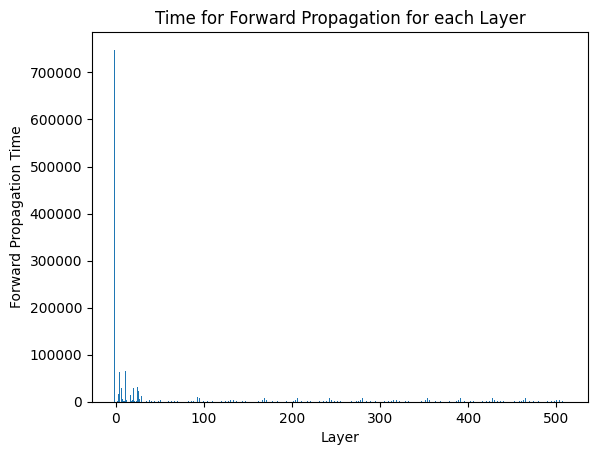

<Figure size 3000x700 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt
plt.bar(x=layer_propagataion_time_32b[' Layer Id'],height=layer_propagataion_time_32b[' Time'])
plt.title('Time for Forward Propagation for each Layer')
plt.xlabel('Layer')
plt.ylabel('Forward Propagation Time')
plt.figure(figsize=(30, 7))
plt.show()

In [47]:
data_a16w16=pd.read_csv("run_result_a8w16.csv")
layer_propagataion_time_a16w16=data_a16w16.iloc[19:530]

layer_propagataion_time_a16w16.head()

,Msg Timestamp,Message,Layer Id,Time,Runtime
19,29650673136,FORWARD_PROPAGATE_LAYER,1,28,CPU
20,29650673136,FORWARD_PROPAGATE_LAYER,2,55,CPU
21,29650673136,FORWARD_PROPAGATE_LAYER,3,11287,CPU
22,29650673136,FORWARD_PROPAGATE_LAYER,4,7950,CPU
23,29650673136,FORWARD_PROPAGATE_LAYER,5,735,CPU


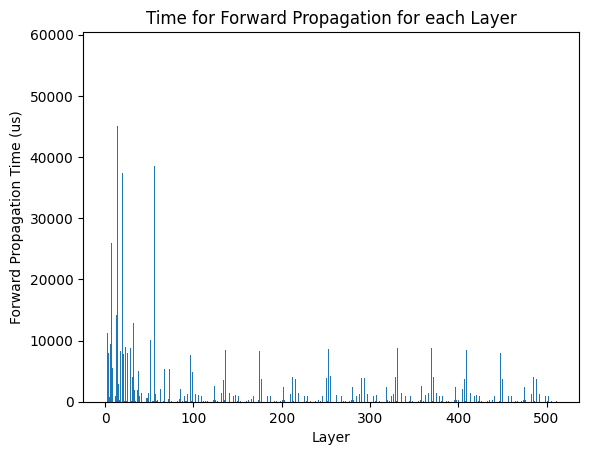

<Figure size 3000x700 with 0 Axes>

In [48]:
plt.bar(x=layer_propagataion_time_a16w16[' Layer Id'],height=layer_propagataion_time_a16w16[' Time'])
plt.title('Time for Forward Propagation for each Layer')
plt.xlabel('Layer')
plt.ylabel('Forward Propagation Time (us)')
plt.figure(figsize=(30, 7))
plt.show()